#  Homework 3

# Part 1 Data Acquisition
### importing libraries and checking the `robots.txt`

In [89]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime, timedelta
import pytz
import re
import time
import urllib.request
import matplotlib.pylab as plt 
import statsmodels.formula.api as sm
import numpy as np


# robots_txt = requests.get('https://news.ycombinator.com/robots.txt')
# print(robots_txt)

## Helper functions

In [90]:
#lists to store the story data in for the df
ranks_list = []
title_lenghts_list = []
ages_list = []
points_list = []
comments_list = []

def get_story_data(the_soup):
        
    
    #for thing in 
    #rank
    for story in the_soup.find(class_='rank'):
        rank = str(story.text).replace('.', '')
        ranks_list.append(int(rank))


    #title
    for title in the_soup.find(class_='titleline'):
        title_lenghts_list.append(len(title.text.strip()))
  
    #age
    for age in the_soup.find(class_='age'):
        age_string = str(age.text).removesuffix(" hours ago").removesuffix(" hour ago")
        calculate_age(age_string)

 
    #points & comments
    for subtext in the_soup.find(class_="subtext"):
        points = 0
        for score in subtext.find(class_="score"):
            points = int(re.search(r'\d+', str(score.text)).group())

        comment_number = 0
        for tag in subtext.find("a"):
            if tag.text.endswith("comments") or tag.text.endswith(" comment"):
                comms = str(tag.text)
                comment_number = int(re.search(r'\d', comms).group())
        
        points_list.append(int(points))
        comments_list.append(int(comment_number))




def calculate_age(age_str):
        # 1 day ago, converted to 24 hours
        if " day ago" in age_str:
            ages_list.append(24)
        elif " days ago" in age_str:
            modified_string = age_str.replace(" days ago", "")
            age_int = int(modified_string)
            ages_list.append(24*age_int)
        elif " minutes ago" in age_str:
            ages_list.append(0)
        elif " minute ago" in age_str:
            ages_list.append(0)
        else:
            ages_list.append(int(age_str))

## Scraping HackerNews

In [ ]:

#url for website
hacker_url = 'https://news.ycombinator.com?p='


#go through the pages on hackernews website
for i in range(5):
     #setting the page to loop through on the website to grab stories
     page = hacker_url + str(i+1)

     #decoding the webpage as html
     with urllib.request.urlopen(page) as response:
        html = response.read()
        html = html.decode("utf-8")

     #saving the html 
     with open ('hackernews' + str(i+1) + ".html", "w" ) as html_file:
         html_file.write(html)

     #create Soup from the saved html
     parsed_soup = BeautifulSoup(html, 'html.parser')

    #collect all the story data from helper method
     get_story_data(parsed_soup)
     time.sleep(5)

    
#save it to a df and csv
stories_df = pd.DataFrame({
    "Rank": ranks_list, 
    "Title_Lengths": title_lenghts_list, 
    "Age_Hours": ages_list, 
    "Points": points_list, 
    "Comments": comments_list
})

#stories_df.to_csv("data/attempt_again_hacker_scrape.csv", index = False)

stories_df.tail(150)




# Part 2 Regression

In [124]:
hacker_regression_df = pd.read_csv('data/hackernews_stories.csv')
print(hacker_regression_df.columns)

#predict the rank of a story based on the other variables collected in the data frame

Index(['Rank', 'Title_Lengths', 'Age_Hours', 'Points', 'Comments'], dtype='object')


### OLS Regression to predict `Rank` from `Points`

In [93]:
pts_ols = sm.ols(formula='Rank ~ Points', data = hacker_regression_df).fit()
pts_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Rank   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                   0.07213
Date:                Tue, 04 Jun 2024   Prob (F-statistic):              0.789
Time:                        12:42:49   Log-Likelihood:                -536.53
No. Observations:                 150   AIC:                             1077.
Df Residuals:                     148   BIC:                             1083.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.6843      0.988     15.868      0.000      13.731      17.638
Points        -0.0022      0.008     -0.269      0.789      -0.019       0.014
==============================================================================
Omnibus:                       60.572   Durbin-Watson:                   0.316
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                8.977
Skew:                          -0.006   Prob(JB):                       0.0112
Kurtosis:                       1.802   Cond. No.                         166.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### `Rank` predicted by `Points`
First I wanted to see if there was any direct correlation between `Rank` and the amount of `Points` a post earns
This data suggests that `Points` is not a useful predictor for the `Rank` of a post on HackerNews

R-Squared = 0.000
* `Points` alone is not a good predictor of the `Rank` of a post
P-Value = 0.789
* `Points` is not a significant predictor of `Rank`

Other factors must be considered to determine the rank of a post. The way HackerNews orginizes it's main page is not be all time popularity, there are likely many considerations including the time of of the posting as well as user interaction with it.

### OLS Regression for predicting the `Rank` based on `Points` and `Age_Hours`

In [94]:

pts_age_ols = sm.ols(formula='Rank ~ Points + Age_Hours', data=hacker_regression_df).fit()
pts_age_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Rank   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     22.71
Date:                Tue, 04 Jun 2024   Prob (F-statistic):           2.54e-09
Time:                        12:42:49   Log-Likelihood:                -516.37
No. Observations:                 150   AIC:                             1039.
Df Residuals:                     147   BIC:                             1048.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.8979      0.907     15.327      0.000      12.106      15.690
Points        -0.0791      0.014     -5.847      0.000      -0.106      -0.052
Age_Hours      1.5908      0.236      6.733      0.000       1.124       2.058
==============================================================================
Omnibus:                       24.564   Durbin-Watson:                   0.522
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                8.677
Skew:                           0.326   Prob(JB):                       0.0131
Kurtosis:                       2.019   Cond. No.                         175.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### `Rank` predicted by `Points` and `Age`
After finding `Points` alone is not a significant predictor of a post's rank, I am not modeling with `Age`.

This data finds that `Points` and `Age` are significant predictors of `Rank`.
* The R-Squared value is 0.384, suggested a moderate amount of variance in `Rank` from these factors
* Coefficent for `Points` is -0.0791 which suggests more `Points` tend to improve the `Rank`
* Coefficient for `Age` is 1.5908 which suggests older posts tend to have lower `Ranks`



### OLS Regression for predicting the `Rank` based on: `Points` , `Age_Hours` , and `Comments`

In [98]:
pts_age_comments_ols = sm.ols(formula='Rank ~ Points + Age_Hours + Comments', data=hacker_regression_df).fit()
pts_age_comments_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Rank   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     15.04
Date:                Tue, 04 Jun 2024   Prob (F-statistic):           1.40e-08
Time:                        12:44:01   Log-Likelihood:                -516.37
No. Observations:                 150   AIC:                             1041.
Df Residuals:                     146   BIC:                             1053.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.8953      1.037     13.405      0.000      11.847      15.944
Points        -0.0791      0.014     -5.792      0.000      -0.106      -0.052
Age_Hours      1.5906      0.240      6.633      0.000       1.117       2.065
Comments       0.0012      0.233      0.005      0.996      -0.459       0.461
==============================================================================
Omnibus:                       24.502   Durbin-Watson:                   0.522
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                8.670
Skew:                           0.326   Prob(JB):                       0.0131
Kurtosis:                       2.020   Cond. No.                         200.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### `Rank` predicted by `Points`, `Age`, and `Comments`
This model provides very similar findings to the previous in terms of `Age` and `Points` and how they can be good moderate predictors of how a posts ranks
This model also finds that `Comments` does not have a significnt effect on the `Rank` of a post
* P-Value for `Comments` is 0.966 which signifies it is not statistically significant

### OLS Regression for predicting the `Rank` based on: `Points`, `Age_Hours`, and `Title_Length`

In [100]:
pts_age_title_ols = sm.ols(formula='Rank ~ Points + Age_Hours + Title_Lengths', data=hacker_regression_df).fit()
pts_age_title_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Rank   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     15.58
Date:                Tue, 04 Jun 2024   Prob (F-statistic):           7.63e-09
Time:                        12:49:56   Log-Likelihood:                -515.74
No. Observations:                 150   AIC:                             1039.
Df Residuals:                     146   BIC:                             1052.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        16.1040      2.178      7.393      0.000      11.799      20.409
Points           -0.0773      0.014     -5.679      0.000      -0.104      -0.050
Age_Hours         1.5834      0.236      6.704      0.000       1.117       2.050
Title_Lengths    -0.0357      0.032     -1.114      0.267      -0.099       0.028
==============================================================================
Omnibus:                       22.874   Durbin-Watson:                   0.517
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.193
Skew:                           0.375   Prob(JB):                       0.0101
Kurtosis:                       2.047   Cond. No.                         455.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### `Rank` predicted by `Points`, `Age`, and `Title Length`
I have mostly found that `Points` and `Age` of the posts tend to be the most significant predicors of `Rank`
In this model, I Included `Title Length` to see if it has any impact
`Title Length` is not a good contribution to predicting the `Rank` of a post on HackerNews
* P-Value for `Title Length` is 0.267
* Coefficient for `Title Length` is -0.0357, meaning the `Rank` may SLIGHTLY improve with longer titles

## Part 2 overall findings
#### "Which is the most useful. Are there linear relationships between any of the variables? How about other relationships like inverse linear (1/x)?"

The most useful Regression Model is the one which includes just `Points` and `Age_Hours` as a predictor for `Rank`.
* This model had the highest R-Squared value of .236, which suggests 23.6% of variability can be explained by the `Points` and `Age_Hours`
* This model also is shown to have linear relationship as the p-values are less than 0.000, indicating a strong linear relationship

None of the models I created are seen to have an inverse linear relationship. This could be found by performing more model tests. Perhaps there is a limit at which the Age of a post being so old means it is not possible for it it be highly ranked. This would recqure scraping more than just the first 5 pages of HackerNews, I assume.


# Part 3 Classification

The front page of HackerNews is 30 posts

I realized there was an error in my scaper in the earlier program that lead to it only scraping the first page
So the data and stories I am scraping for this part is not entirely the same as the preceding parts
There seems to be something wrong with my helper function that is scraping the first page 5 times, then it is scraping the first 5 pages 5 times... For this part, I will just use the last 150 rows as those represent the first 5 pages that were scraped.

distribution of front page Front_Page
0    120
1     30
Name: count, dtype: int64
Optimization terminated successfully.
         Current function value: 0.430681
         Iterations 6


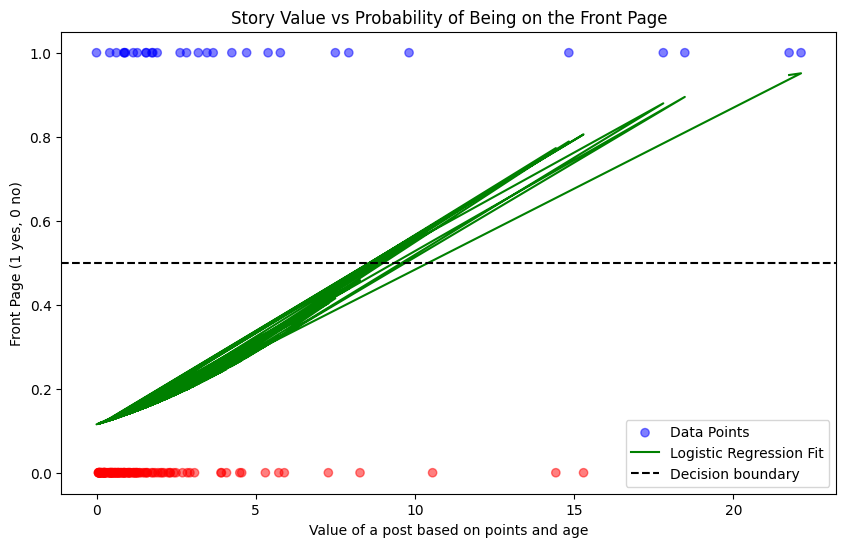

                           Logit Regression Results                           
Dep. Variable:             Front_Page   No. Observations:                  150
Model:                          Logit   Df Residuals:                      148
Method:                           MLE   Df Model:                            1
Date:                Wed, 05 Jun 2024   Pseudo R-squ.:                  0.1393
Time:                        15:00:46   Log-Likelihood:                -64.602
converged:                       True   LL-Null:                       -75.060
Covariance Type:            nonrobust   LLR p-value:                 4.797e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0392      0.280     -7.294      0.000      -2.587      -1.491
Value          0.2263      0.061      3.732      0.000       0.107       0.345


In [166]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

first_page_thresh = 30
total_rows = sum(1 for line in open('data/retest_hacker_news.csv'))
#front page is a binary value
#getting the last 150 elements of the csv to utilize for the classification
#this is because of the weird loading of the CSV of the scraped stories
hacker_df = pd.read_csv('data/retest_hacker_news.csv', skiprows=range(1, total_rows -150 ))

#if the rank is less than or equal to 30, recieve a one, meaning it is on the front page
hacker_df['Front_Page'] = np.where(hacker_df['Rank']<= first_page_thresh, 1, 0)
print(f"distribution of front page {hacker_df['Front_Page'].value_counts()}")


#utilizing a scoring function to determine the value of a post
#new row as value
c = 2
p = 1.5
hacker_df['Value'] = hacker_df['Points']/((hacker_df['Age_Hours'] + c) ** p)

#logisitcal regression model to predict the front page status based on a post's value
logit_model = sm.Logit(hacker_df['Front_Page'], sm.add_constant(hacker_df['Value']))
l_result = logit_model.fit()

# plotting the rank of a post vs the value of the post
plt.figure(figsize=(10,6))
fp_colors = np.where(hacker_df['Front_Page'] == 1, 'blue', 'red')
plt.scatter(hacker_df['Value'], hacker_df['Front_Page'] , c = fp_colors, alpha = 0.5,label = 'Data Points')
prediction = l_result.predict(sm.add_constant(hacker_df['Value']))
plt.plot(hacker_df['Value'], prediction, color = 'green', label= 'Logistic Regression Fit')
plt.axhline(0.5, color = 'black', linestyle= '--', label= 'Decision boundary')
plt.ylabel('Front Page (1 yes, 0 no)')
plt.xlabel('Value of a post based on points and age')
plt.title('Story Value vs Probability of Being on the Front Page')
plt.legend()
plt.show()

print(l_result.summary())



### Logistical Regresssion Conclusion

The Pseudo R-Squared value for this Logit Regression is 0.1393. This suggests a 13.93% impact on the front page status of a post based on the `Value` equation from points and age of the post. This is a pretty low determining factor for how a post might get onto the front page of Hacker News.

The const coefficient is, however, -2.0392. Implying that the chance of being on the front page with a post `Value` of 0 is very unlikely. This is due to the negative value.
The `Value` coefficient is 0.2263. Which indicates that as the `Value` of a post increases with each point, the change of being on the front page is increased by .2263. Based on the visualization of the prediciton, it seems when the `Value` of a post reaches around 10-12, that post is more likely to reach the front page. The many blue points that seem to have a lower `Value` are likely older posts.
Both of the coeefficents have a P-Value of 0.000 meaning they are statistically significant. 


Ultimately, this Logit Regression does show that the value of a post is a significnat predictor of front page appearence. However, there are certainly many other factors than impact the front page appearance. Things such as time of day, the popularity of the user posting, and the topic. 